In [1]:
import os
import cv2
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import rasterio as rs
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, 
    BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate,
    RandomContrast
)

2023-07-26 16:22:22.171900: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 16:22:22.201430: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 16:22:22.202055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 16:22:22.732927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMG_HEIGHT = 64
IMG_WIDTH = IMG_HEIGHT
IMG_CHANNELS = 2

In [3]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

my_unet = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
my_unet.compile(optimizer=Adam(learning_rate=1e-4),  loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
diretorio_dados = "/home/emanoelcepr/Imagens/imagens_originais/Sentinel-2/dados/"

In [5]:
# Defina o diretório onde os arquivos foram salvos

# path = "/home/cristiano/Imagens/"
path = "/home/emanoelcepr/Imagens/"


diretorio_imagens = path + "imagens_originais/Sentinel-2/teste_processadas/"

# Caminhos completos para os arquivos X_test.npy 
X_test_file = os.path.join(diretorio_imagens, 'X_test.npy')
Y_test_file = os.path.join(diretorio_imagens, 'Y_test.npy')
Z_test_file = os.path.join(diretorio_imagens, 'Z_test.npy')


# Carregar os dados de volta para o notebook
X_test = np.load(X_test_file)
Y_test = np.load(Y_test_file)
Z_test = np.load(Z_test_file)


# Verificar a forma (shape) das arrays carregadas
print('Shape de X_train:', X_test.shape)
print('Shape de Y_train:', Y_test.shape)
print('Shape de Z_train:', Z_test.shape)


Shape de X_train: (1288, 64, 64, 2)
Shape de Y_train: (1288, 64, 64, 1)
Shape de Z_train: (1288, 64, 64, 3)


In [6]:
# use the best epoch
# my_unet.load_weights("/home/cristiano/Imagens/imagens_originais/Sentinel-2/treino_processadas/model70-30.h5")
my_unet.load_weights("/home/emanoelcepr/Imagens/imagens_originais/Sentinel-2/treino_processadas/model70-30.h5")
test_preds = my_unet.predict(X_test)

# Threshold the predictions

preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)
preds_test_thresh = preds_test_thresh.reshape((len(X_test), IMG_WIDTH, IMG_HEIGHT, 1))

41/41 [==============================] - 19s 448ms/step


In [7]:
print("Evaluate on test data")
results = my_unet.evaluate(X_test, Y_test)
print("test loss: ", results)

Evaluate on test data
41/41 [==============================] - 19s 451ms/step - loss: 0.0103 - accuracy: 0.9995
test loss:  [0.010325479321181774, 0.999527633190155]


In [8]:
"""IOU"""

mean_iou1 = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou1.update_state(Y_test, preds_test_thresh, sample_weight=None)
iou = mean_iou1.result().numpy()
print("IOU: ", iou)

IOU:  0.95468146


In [9]:
"""Accuracy"""

acc1 = tf.keras.metrics.Accuracy()
acc1.update_state(Y_test, preds_test_thresh)
acc = acc1.result().numpy()
print("acurácia: ", acc)

acurácia:  0.99952763


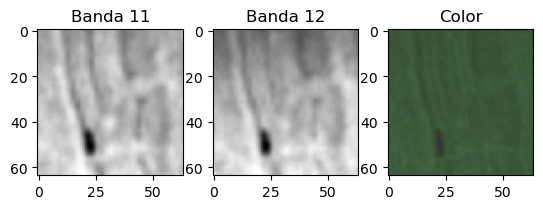

In [10]:
import matplotlib.pyplot as plt

# Selecionar a primeira amostra da array X_test, que contém a imagem composta pelas duas bandas
bandas = X_test[9]
color = Z_test[9]

# Separar as bandas individuais (assumindo que as bandas estão na última dimensão)
banda11 = bandas[:, :, 0]
banda12 = bandas[:, :, 1]

# Plotar as bandas individualmente
plt.subplot(1, 3, 1)
plt.imshow(banda11, cmap='gray')
plt.title('Banda 11')

plt.subplot(1, 3, 2)
plt.imshow(banda12, cmap='gray')
plt.title('Banda 12')

plt.subplot(1, 3, 3)
color_normalized = color / 255.0
plt.imshow(color_normalized)
plt.title('Color')


plt.show()

In [11]:
# Função para calcular a área total representada pelos pixels "true" na imagem "Segmentação Predita"
def calcular_area_total(img_pred):
    # Área de cada pixel (em metros quadrados)
    area_por_pixel_m2 = 10

    # Obter os índices dos pixels com valor 1
    indices_pixels_1 = np.argwhere(img_pred == 1)

    # Se houver algum pixel com valor 1
    if len(indices_pixels_1) > 0:
        # Obter a posição do primeiro pixel com valor 1 (linha e coluna)
        linha_primeiro_pixel_1, coluna_primeiro_pixel_1 = indices_pixels_1[0]

        # Contar a quantidade de pixels "true" na imagem (valor 1 na matriz)
        num_true_pixels = len(indices_pixels_1)

        # Calcular a área total (área por pixel multiplicada pelo número de pixels "true")
        area_total_m2 = num_true_pixels * area_por_pixel_m2

        # Retornar a área total e a posição do primeiro pixel encontrado
        return area_total_m2, (linha_primeiro_pixel_1, coluna_primeiro_pixel_1)
    else:
        print("Nenhum pixel com valor 1 encontrado na matriz.")
        return 0, None


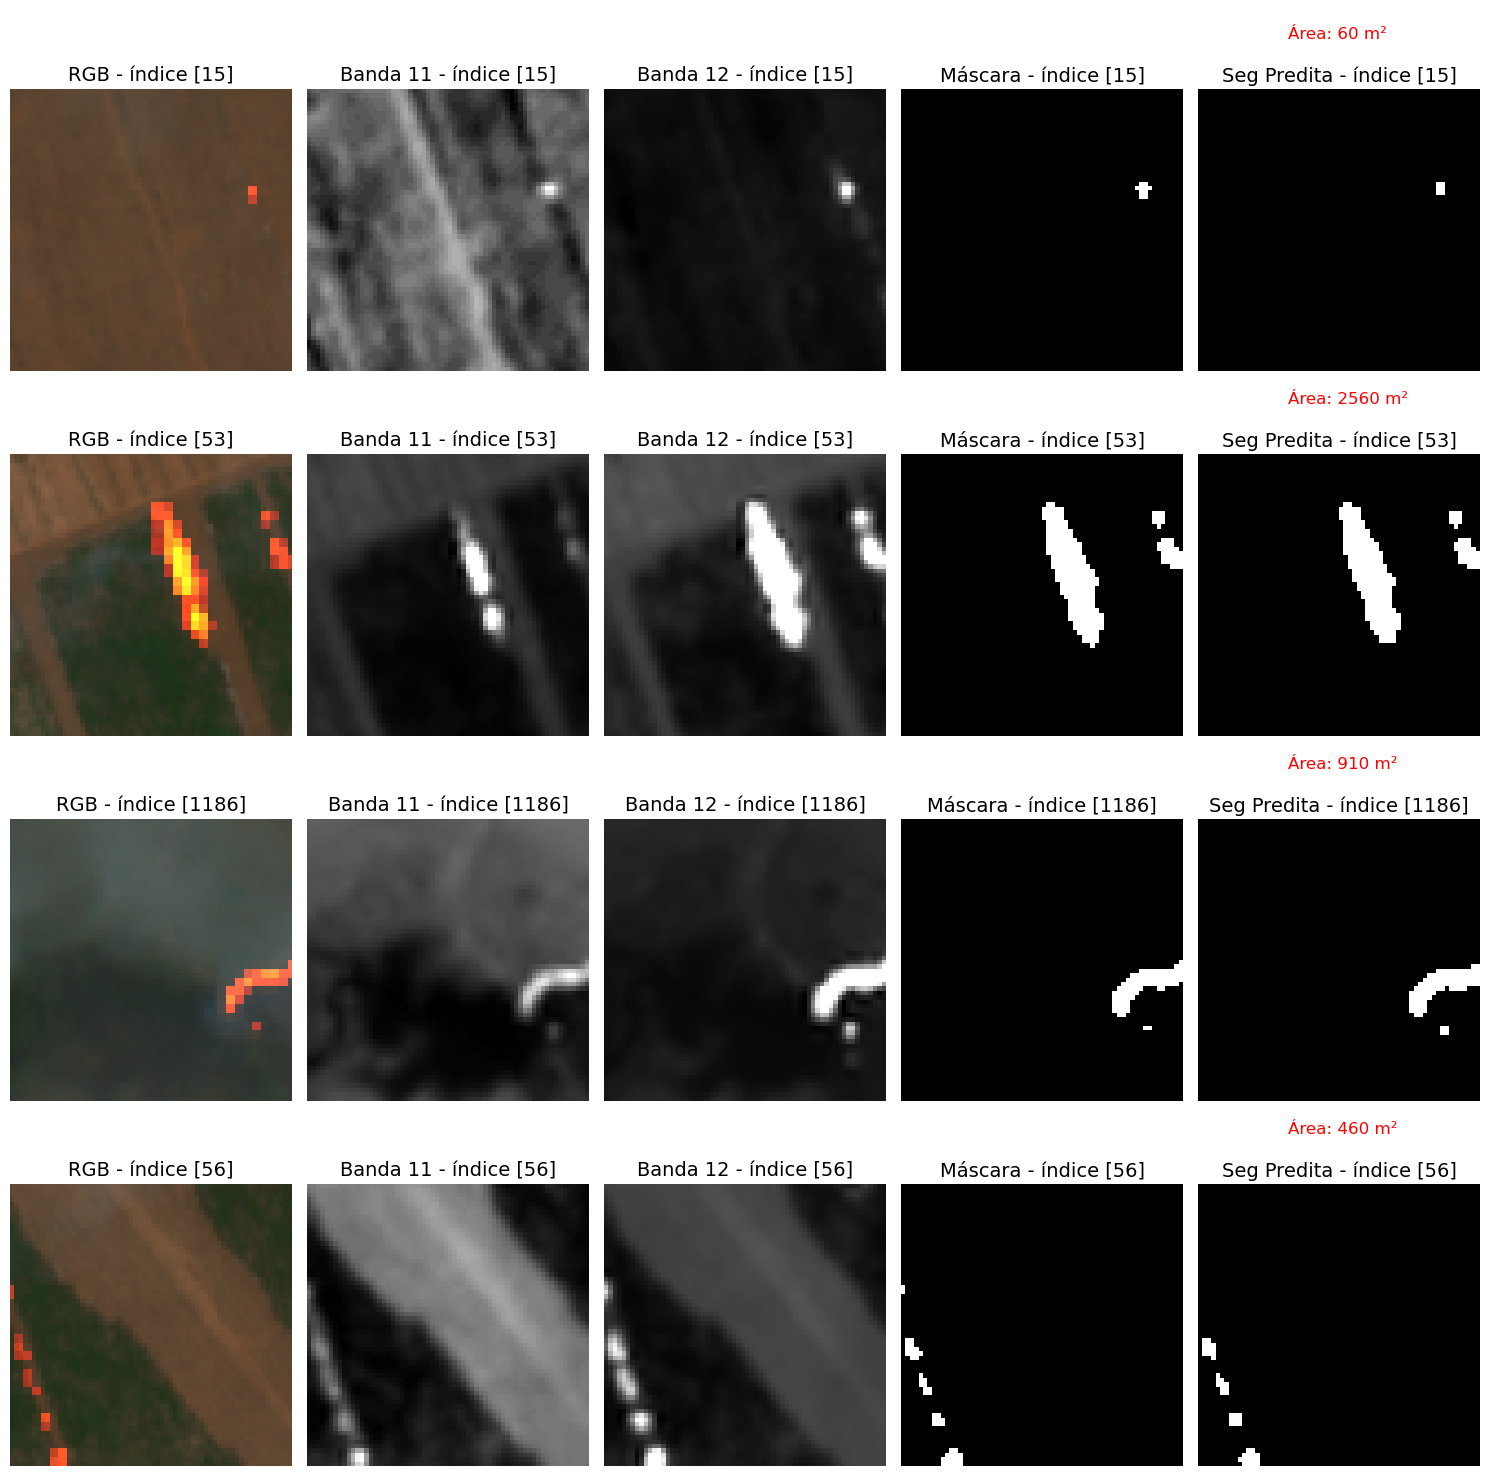

In [12]:

def plot_resultado(quantidade=4, random=14):
    # indices = df_test.sample(quantidade, random_state=random).index.values
    indices = [15, 53, 1186, 56]
    plt.figure(figsize=(15, 15))
    j = 1

    lista_imagens = []

    # Listar todos os arquivos no diretório
    arquivos = os.listdir(diretorio_imagens)

    # Filtrar os arquivos para incluir somente os que contêm "Wildfires"
    arquivos_filtrados = [arquivo for arquivo in arquivos if "Wildfires" in arquivo]

    # Ordenar os arquivos filtrados em ordem alfabética
    arquivos_filtrados.sort()

    # Iterar sobre os arquivos filtrados e carregar as imagens .tiff no array
    for arquivo in arquivos_filtrados:
        caminho_arquivo = os.path.join(diretorio_imagens, arquivo)
        imagem = Image.open(caminho_arquivo)
        lista_imagens.append(imagem)

    for i in range(quantidade):
        # rgb = Z_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        rgb = lista_imagens[indices[i]]
        b1 = X_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b2 = X_test[indices[i], :, :, 1].reshape((IMG_HEIGHT, IMG_WIDTH))
        seg = Y_test.reshape((-1, IMG_HEIGHT, IMG_WIDTH))[indices[i]]
        img_pred = preds_test_thresh[indices[i]].reshape((IMG_HEIGHT, IMG_WIDTH))

        imgs = [b1, b2, seg]
        
        plt.subplot(quantidade, 5, j)
        plt.imshow(rgb)
        plt.title('RGB - índice [' + str(indices[i]) + ']', fontsize=14)
        plt.axis('off')
        j += 1

        for img, nome in zip(imgs, ['Banda 11', 'Banda 12', 'Máscara']):
            plt.subplot(quantidade, 5, j)
            plt.imshow(img, cmap='gray')
            plt.title(f"{nome} - índice [{indices[i]}]", fontsize=14)
            plt.axis('off')
            j += 1

        # Calcular a área total representada pelos pixels "true" na imagem "Segmentação Predita"
        area_total_m2 = calcular_area_total(img_pred) 

        # Adicionar o valor da área abaixo da label "Segmentação Predita"
        plt.subplot(quantidade, 5, j)
        plt.imshow(img_pred, cmap='gray')
        plt.title(f"Seg Predita - índice [{indices[i]}]", fontsize=14)
        plt.text(20, -15, f"\nÁrea: {area_total_m2[0]} m²", ha='left', va='center', fontsize=12, color='red')
        plt.axis('off')
        j += 1

    plt.tight_layout()
    plt.show()

# Substitua Z_test, X_test, Y_test e preds_test_thresh pelas matrizes adequadas.
plot_resultado()



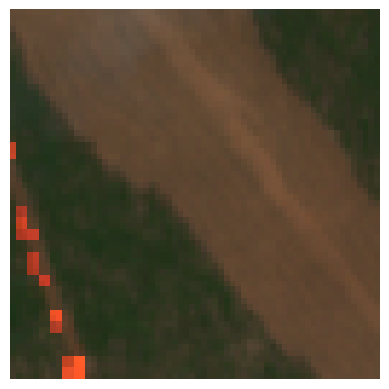

In [13]:
from PIL import Image
import os
import matplotlib.pyplot as plt

lista_imagens = []

# Listar todos os arquivos no diretório
arquivos = os.listdir(diretorio_imagens)

# Filtrar os arquivos para incluir somente os que contêm "Wildfires"
arquivos_filtrados = [arquivo for arquivo in arquivos if "Wildfires" in arquivo]

# Ordenar os arquivos filtrados em ordem alfabética
arquivos_filtrados.sort()

# Iterar sobre os arquivos filtrados e carregar as imagens .tiff no array
for arquivo in arquivos_filtrados:
    caminho_arquivo = os.path.join(diretorio_imagens, arquivo)
    imagem = Image.open(caminho_arquivo)
    lista_imagens.append(imagem)

# Plotar a primeira imagem da lista
if lista_imagens:
    plt.imshow(lista_imagens[56])  # Mostrar a primeira imagem, pois agora estão ordenadas
    plt.axis('off')  # Opcional, para ocultar os eixos
    plt.show()
else:
    print("Nenhuma imagem .tiff contendo 'Wildfires' encontrada no diretório.")


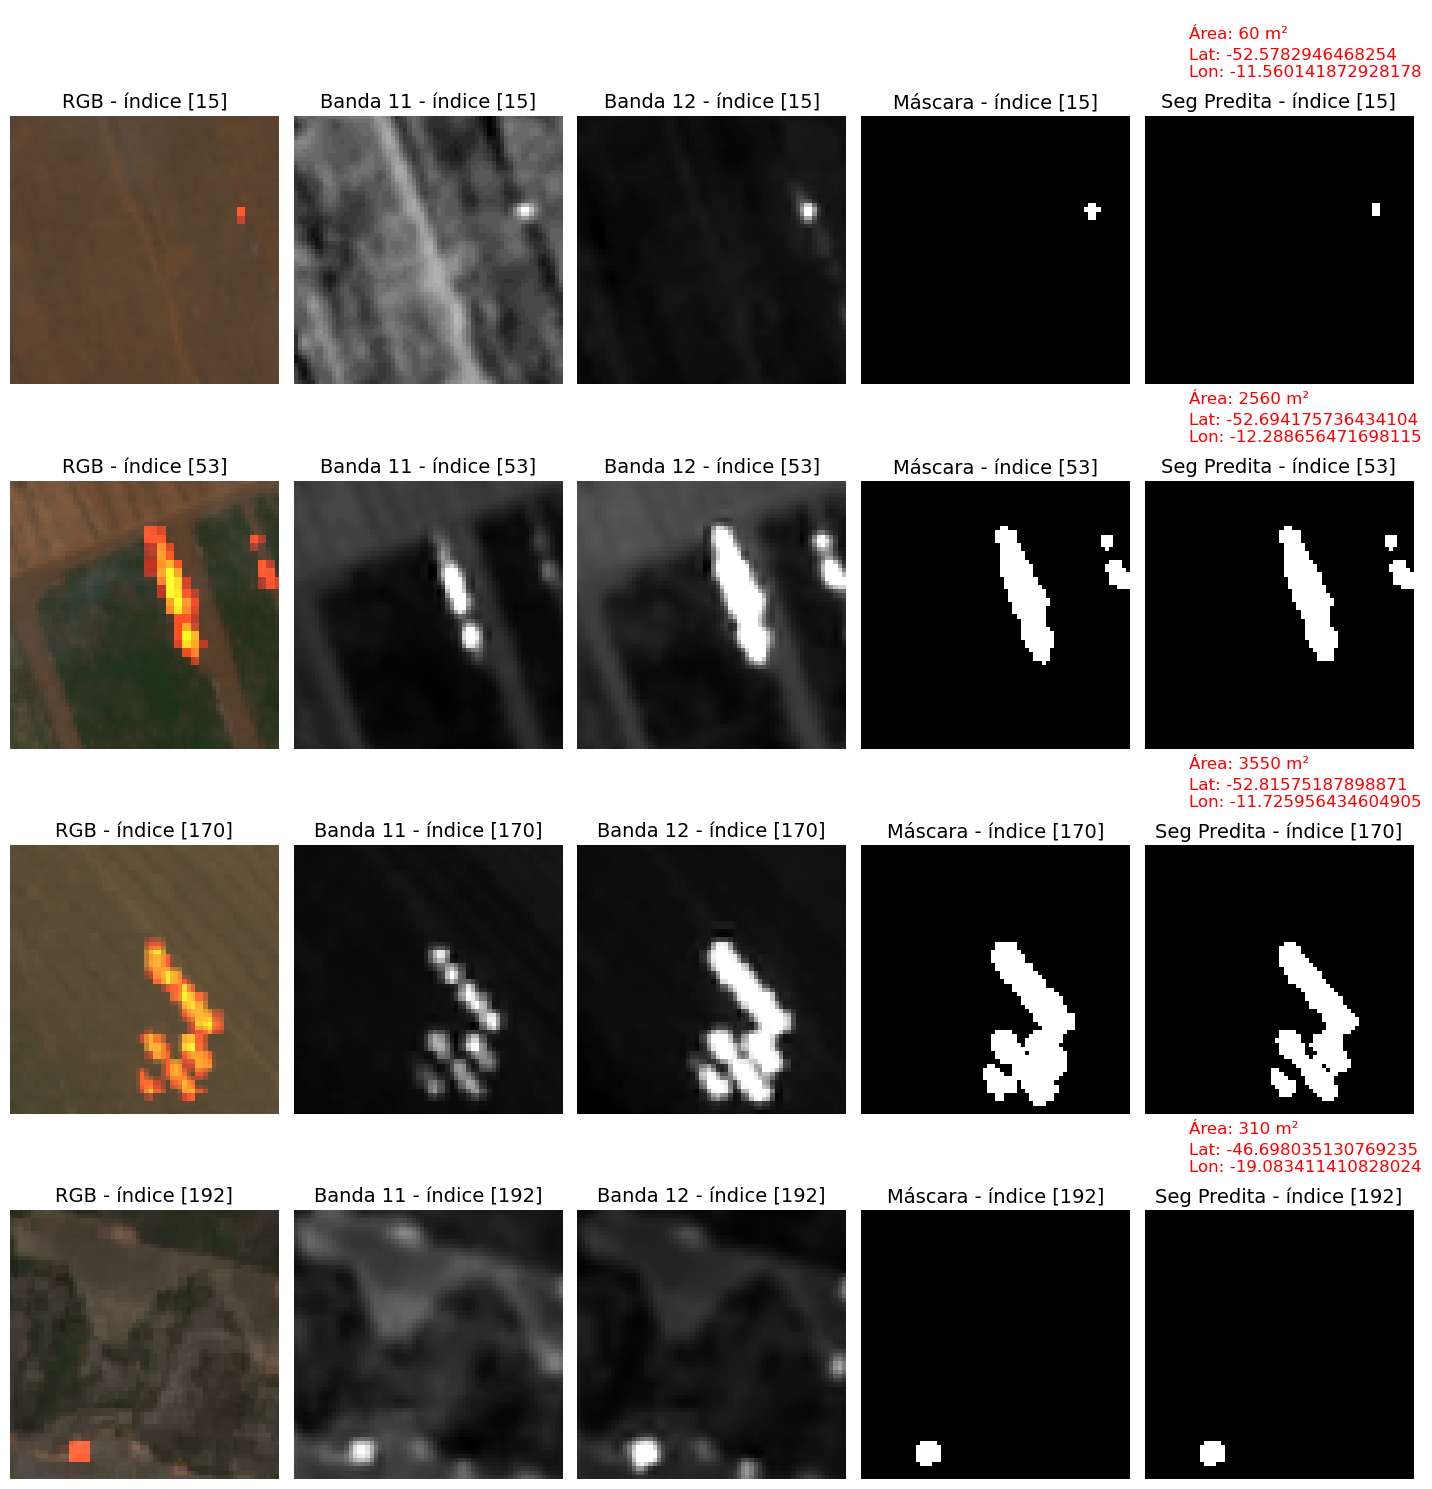

In [39]:
# Função para encontrar a latitude e longitude do primeiro pixel com valor superior a 180 em uma imagem
def encontrar_latitude_longitude_por_posicao(id_imagem):
    # Ler o arquivo metadata.csv
    metadata_file = os.path.join(diretorio_dados, "metadados.csv")
    df_metadados = pd.read_csv(metadata_file)

    # Encontrar a linha correspondente à imagem pelo índice da imagem
    row = df_metadados[df_metadados["ID_Imagem"] == id_imagem]

    # Obter os valores de latitude e longitude
    latitude = row["Latitude"]
    longitude = row["Longitude"]

    return np.mean(latitude), np.mean(longitude)

def plot_resultado(quantidade=4, random=14):
    # indices = df_test.sample(quantidade, random_state=random).index.values
    indices = [15, 53, 170, 192]
    plt.figure(figsize=(15, 15))
    j = 1

    lista_imagens = []

    # Listar todos os arquivos no diretório
    arquivos = os.listdir(diretorio_imagens)

    # Filtrar os arquivos para incluir somente os que contêm "Wildfires"
    arquivos_filtrados = [arquivo for arquivo in arquivos if "Wildfires" in arquivo]

    # Ordenar os arquivos filtrados em ordem alfabética
    arquivos_filtrados.sort()

    # Iterar sobre os arquivos filtrados e carregar as imagens .tiff no array
    for arquivo in arquivos_filtrados:
        caminho_arquivo = os.path.join(diretorio_imagens, arquivo)
        imagem = Image.open(caminho_arquivo)
        lista_imagens.append(imagem)

    for i in range(quantidade):
        # rgb = Z_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        rgb = lista_imagens[indices[i]]
        b1 = X_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b2 = X_test[indices[i], :, :, 1].reshape((IMG_HEIGHT, IMG_WIDTH))
        seg = Y_test.reshape((-1, IMG_HEIGHT, IMG_WIDTH))[indices[i]]
        img_pred = preds_test_thresh[indices[i]].reshape((IMG_HEIGHT, IMG_WIDTH))

        imgs = [b1, b2, seg]
        
        plt.subplot(quantidade, 5, j)
        plt.imshow(rgb)
        plt.title('RGB - índice [' + str(indices[i]) + ']', fontsize=14)
        plt.axis('off')
        j += 1

        for img, nome in zip(imgs, ['Banda 11', 'Banda 12', 'Máscara']):
            plt.subplot(quantidade, 5, j)
            plt.imshow(img, cmap='gray')
            plt.title(f"{nome} - índice [{indices[i]}]", fontsize=14)
            plt.axis('off')
            j += 1

        # Calcular a área total representada pelos pixels "true" na imagem "Segmentação Predita"
        area_total_m2 = calcular_area_total(img_pred)
        
        # Encontrar a latitude e longitude para a imagem de ID
        latitude, longitude = encontrar_latitude_longitude_por_posicao(indices[i])

        # Adicionar o valor da área abaixo da label "Segmentação Predita"
        plt.subplot(quantidade, 5, j)
        plt.imshow(img_pred, cmap='gray')
        plt.title(f"Seg Predita - índice [{indices[i]}]", fontsize=14)
        plt.text(10, -22, f"\nÁrea: {area_total_m2[0]} m²", ha='left', va='center', fontsize=12, color='red')
        plt.text(10, -15, f"\nLat: {latitude} \nLon: {longitude}", ha='left', va='center', fontsize=12, color='red')
        plt.axis('off')
        j += 1

    plt.tight_layout()
    plt.show()

# Substitua Z_test, X_test, Y_test e preds_test_thresh pelas matrizes adequadas.

plot_resultado()


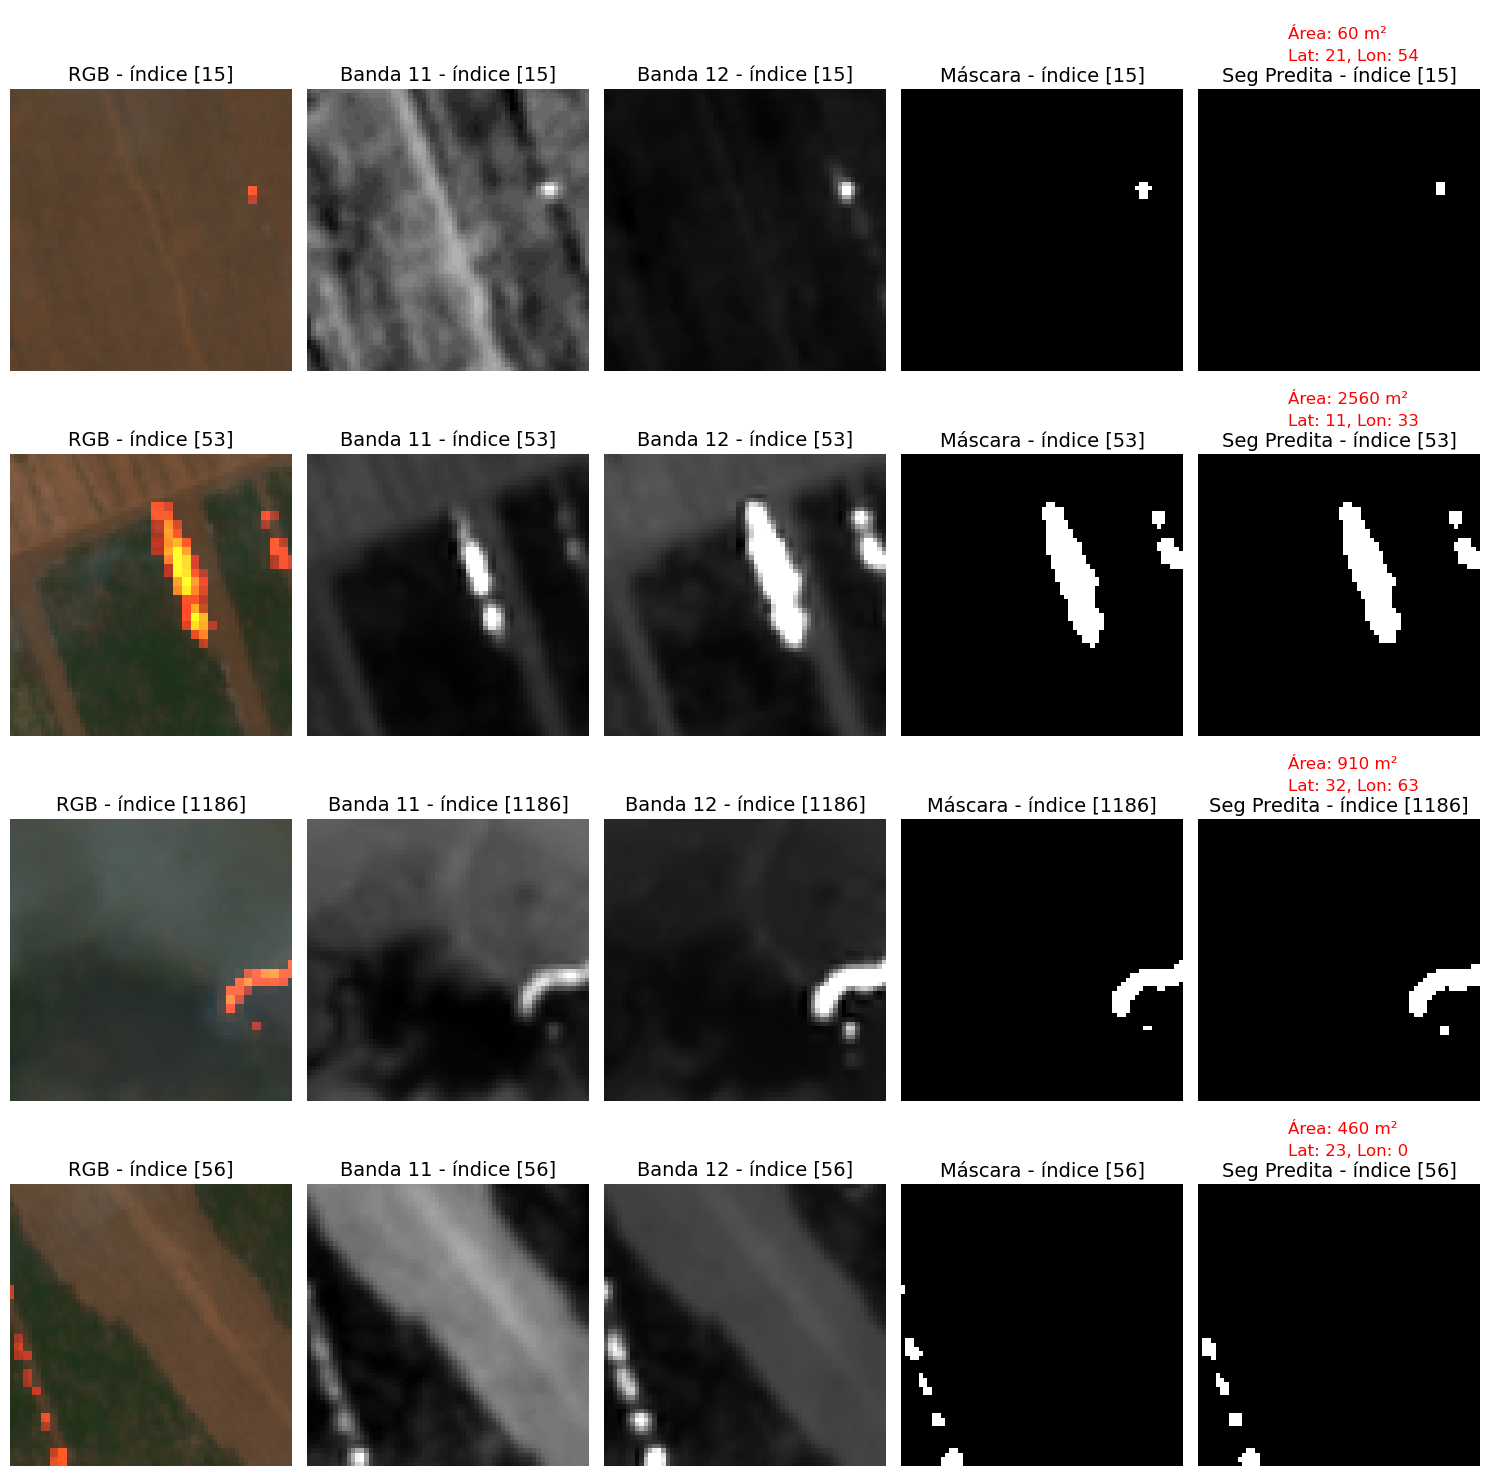

In [ ]:
# Função para encontrar a latitude e longitude do primeiro pixel com valor superior a 180 em uma imagem
def encontrar_latitude_longitude_por_posicao(id_imagem):
    for latitude in range(id_imagem.shape[0]):
        for longitude in range(id_imagem.shape[1]):
            if id_imagem[latitude, longitude] > 180:
                return latitude, longitude

    return None

def plot_resultado(quantidade=4, random=14):
    # indices = df_test.sample(quantidade, random_state=random).index.values
    indices = [15, 53, 1186, 56]
    plt.figure(figsize=(15, 15))
    j = 1

    lista_imagens = []

    # Listar todos os arquivos no diretório
    arquivos = os.listdir(diretorio_imagens)

    # Filtrar os arquivos para incluir somente os que contêm "Wildfires"
    arquivos_filtrados = [arquivo for arquivo in arquivos if "Wildfires" in arquivo]

    # Ordenar os arquivos filtrados em ordem alfabética
    arquivos_filtrados.sort()

    # Iterar sobre os arquivos filtrados e carregar as imagens .tiff no array
    for arquivo in arquivos_filtrados:
        caminho_arquivo = os.path.join(diretorio_imagens, arquivo)
        imagem = Image.open(caminho_arquivo)
        lista_imagens.append(imagem)

    for i in range(quantidade):
        # rgb = Z_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        rgb = lista_imagens[indices[i]]
        b1 = X_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b2 = X_test[indices[i], :, :, 1].reshape((IMG_HEIGHT, IMG_WIDTH))
        seg = Y_test.reshape((-1, IMG_HEIGHT, IMG_WIDTH))[indices[i]]
        img_pred = preds_test_thresh[indices[i]].reshape((IMG_HEIGHT, IMG_WIDTH))

        imgs = [b1, b2, seg]
        
        plt.subplot(quantidade, 5, j)
        plt.imshow(rgb)
        plt.title('RGB - índice [' + str(indices[i]) + ']', fontsize=14)
        plt.axis('off')
        j += 1

        for img, nome in zip(imgs, ['Banda 11', 'Banda 12', 'Máscara']):
            plt.subplot(quantidade, 5, j)
            plt.imshow(img, cmap='gray')
            plt.title(f"{nome} - índice [{indices[i]}]", fontsize=14)
            plt.axis('off')
            j += 1

        # Calcular a área total representada pelos pixels "true" na imagem "Segmentação Predita"
        area_total_m2 = calcular_area_total(img_pred)
        
        # Encontrar a latitude e longitude para a imagem de ID
        latitude, longitude = encontrar_latitude_longitude_por_posicao(b2)

        # Adicionar o valor da área abaixo da label "Segmentação Predita"
        plt.subplot(quantidade, 5, j)
        plt.imshow(img_pred, cmap='gray')
        plt.title(f"Seg Predita - índice [{indices[i]}]", fontsize=14)
        plt.text(20, -15, f"\nÁrea: {area_total_m2[0]} m²", ha='left', va='center', fontsize=12, color='red')
        plt.text(20, -10, f"\nLat: {latitude}, Lon: {longitude}", ha='left', va='center', fontsize=12, color='red')
        plt.axis('off')
        j += 1

    plt.tight_layout()
    plt.show()

# Substitua Z_test, X_test, Y_test e preds_test_thresh pelas matrizes adequadas.
plot_resultado()
